## Import modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import SimpleITK as sitk

# Part I: Basic operation with SimpleITK

## Load an image using SimpleITK and display the image information

In [2]:
fn_img0 = 'img0.png'
img0 = sitk.ReadImage(fn_img0)
print(img0.GetOrigin())
print(img0.GetSpacing())
print(img0.GetDirection())

(0.0, 0.0)
(1.0, 1.0)
(1.0, 0.0, 0.0, 1.0)


## Display the image

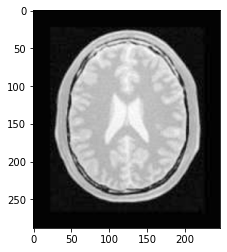

In [3]:
# %% Get numpy array from image

img0_array = sitk.GetArrayFromImage(img0)

plt.imshow(img0_array, cmap='gray')
plt.show()

# Part II: Image Registration Example

## 1. Read Image for Registration

In [4]:
fixed_image =  sitk.ReadImage('img0.png', sitk.sitkFloat32)
moving_image = sitk.ReadImage('img1.png', sitk.sitkFloat32)

## 2. Initialization

Use `CenteredTransformInitializer` to align the centers of the two volumes and set the center of rotation to the center of the fixed image.

In [5]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image, 
    moving_image, 
    sitk.Euler2DTransform(), 
    sitk.CenteredTransformInitializerFilter.GEOMETRY)

print(initial_transform)


# Manual initialization
my_initialization = sitk.Euler2DTransform()
my_initialization.SetTranslation((7.2, 8.4))
print(my_initialization)

itk::simple::Transform
 Euler2DTransform (00000285D4140F20)
   RTTI typeinfo:   class itk::Euler2DTransform<double>
   Reference Count: 1
   Modified Time: 1299
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 -0 
     0 1 
   Offset: [0, 0]
   Center: [123, 143.5]
   Translation: [0, 0]
   Inverse: 
     1 0 
     0 1 
   Singular: 0
   Angle       = 0

itk::simple::Euler2DTransform
 Euler2DTransform (00000285D4141070)
   RTTI typeinfo:   class itk::Euler2DTransform<double>
   Reference Count: 1
   Modified Time: 1302
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 0 
     0 1 
   Offset: [7.2, 8.4]
   Center: [0, 0]
   Translation: [7.2, 8.4]
   Inverse: 
     1 0 
     0 1 
   Singular: 0
   Angle       = 0



## 3. Resample the moving image

In [6]:
moving_resampled = sitk.Resample(moving_image, 
                                 fixed_image,
                                 initial_transform, # Change to different transforms
                                 sitk.sitkLinear,
                                 0.0,
                                 moving_image.GetPixelID()) # output pixel type

## Exercise I

1. Replace the initial transform with `my_initialization` in the above code and show the resampled image.
2. Change `sitk.sitkLinear` to other interpolators and show the results. Do you see any differences?

## 4. Start Image Registration

In [10]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
#registration_method.SetMetricAsCorrelation()
registration_method.SetMetricAsMeanSquares()

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=0.001, 
    numberOfIterations=100, 
    convergenceMinimumValue=1e-7, 
    convergenceWindowSize=3)

# The number of iterations involved in computations are defined by 
# the convergence window size

# Estimating scales of transform parameters a step sizes, from the 
# maximum voxel shift in physical space caused by a parameter change. 
registration_method.SetOptimizerScalesFromPhysicalShift()

# Initialize registration
registration_method.SetInitialTransform(initial_transform, inPlace=False)

## 5. Monitor the registration process

In [11]:
# Callback invoked when the StartEvent happens, sets up our new data.
def clear_values():
    global metric_values
    
    metric_values = []


# Connect observers so that we can perform plotting 
# during registration.
registration_method.AddCommand(sitk.sitkStartEvent, 
                               clear_values)
    
# Callback invoked when the IterationEvent happens, update our data 
# and display new figure.    
def save_values(registration_method):
    global metric_values
    value = registration_method.GetMetricValue()
    metric_values.append(value)
    print('Iteration {}: metric value {:.4f}'.format(
        len(metric_values), value))
    
    
# Connect observers so that we can perform plotting 
# during registration.
registration_method.AddCommand(sitk.sitkIterationEvent, 
                               lambda: save_values(registration_method))


0

## 6. Get the final registration result

In [12]:
final_transform = registration_method.Execute(fixed_image, 
                                              moving_image)

print('Final metric value: {0}'.format(
    registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(
    registration_method.GetOptimizerStopConditionDescription()))

moving_resampled = sitk.Resample(moving_image,
                                 fixed_image,
                                 final_transform,
                                 sitk.sitkLinear,
                                 0.0,
                                 moving_image.GetPixelID())

# Save image and transformation to local drive
#
#moving_resampled = sitk.Cast(moving_resampled, sitk.sitkUInt8)
#sitk.WriteImage(moving_resampled, 'moving_resampled.png')
#sitk.WriteTransform(final_transform, 'final_transform.txt')

Iteration 1: metric value 4291.9936
Iteration 2: metric value 4109.9925
Iteration 3: metric value 3945.1845
Iteration 4: metric value 3860.7622
Iteration 5: metric value 3719.9541
Iteration 6: metric value 3599.7315
Iteration 7: metric value 3529.1372
Iteration 8: metric value 3448.7134
Iteration 9: metric value 3370.4280
Iteration 10: metric value 3329.1399
Iteration 11: metric value 3231.4491
Iteration 12: metric value 3190.3910
Iteration 13: metric value 3083.6679
Iteration 14: metric value 3033.2142
Iteration 15: metric value 2925.9740
Iteration 16: metric value 2863.2046
Iteration 17: metric value 2773.4209
Iteration 18: metric value 2667.3667
Iteration 19: metric value 2551.9047
Iteration 20: metric value 2360.4100
Iteration 21: metric value 2002.4411
Iteration 22: metric value 1549.5707
Iteration 23: metric value 1139.8753
Iteration 24: metric value 700.1422
Iteration 25: metric value 191.3190
Iteration 26: metric value 24.9815
Iteration 27: metric value 20.8451
Iteration 28: me

## Exercise II

3. Use `matplotlib.pyplot.plot` to plot the metric values over iterations.
4. Show the initial difference image and final difference image after registration.
5. Use correlation as image registration metric and repeat steps 3 and 4.